In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np

from utils import *

## Algorithme de Metropolis-Hastings 

- On commence par choisir un point $x_0$, comme étant le premier échantillon de notre loi cible, ainsi qu'une probabilité de transition $g$, en donnant les fonctions correspondant à $g_y(x)$ et $g(x)$, $\forall x,y \in E$.
- Ensuite nous itérons sur $t$ allant de 0 à $N-1$ inclus (le nombre d'itérations voulu)
\begin{itemize}
    - On tire $x$ avec $g_{x_t}(x)$  
    - On pose $\alpha \coloneqq \frac{ \pi(x) g_x(x_t)}{\pi(x_t) g_{x_t}(x)}$ (notons que si nous ne possédons qu'une densité proportionnelle à $\pi$, $f$ nous pouvons poser $\alpha \coloneqq \frac{ f(x) g_x(x_t)}{f(x_t) g_{x_t}(x)}$)  
    - On tire $u \in [0;1]$, tel que $u  \sim \mathcal{U}(0,1)$ 
        - Si $u \leqslant \alpha$ alors : $x_{t+1} \coloneqq x$  
        - Sinon : on conserve l'état précédent $x_{t+1} \coloneqq x_t$  
- La séquence $\{x_0,x_1, \ldots ,x_{N-1}\}$ constitue donc l'échantillon obtenu à partir de la chaîne de Markov associée à la loi $\pi$


Voici une implémentation de l'algorithme en python :

# Implémentation de hastings_metropolis :

In [ ]:
#Tire aléatoirement le prochain état d'une chaîne de Markov, représentée par une matrice
def next_state_markov(x:int,transitions:np.array)->int:
        return np.random.choice(len(transitions),p=transitions[x])
    

#Implémentation de HM
def hastings_metropolis_tirage(x0:int,distribution_cible,proposition : np.array,iterations:int = 1000)->np.array:
    x_t = x0
    tirage = [x_t]

    for _ in range(iterations):
        # tirage de x
        x = next_state_markov(x_t,proposition)

        # a:= (PI(x)*g(x_t|x)) / (PI(x_t)*g(x|x_t))
        pi_xt = distribution_cible(x_t)
        pi_x = distribution_cible(x)
        g_xt_x = proposition[x_t][x]
        g_x_xt = proposition[x][x_t]
        if pi_xt * g_xt_x == 0 : alpha = 1 # on évit e la division par 0
        else : alpha = min(1,(pi_x * g_x_xt)/(pi_xt * g_xt_x))

        #on tire u de manière uniforme dans [0;1]
        u = np.random.uniform(0,1)

        # Si u <= a alors : x_(t+1) = x'
        # Sinon : x_(t+1) = x_t
        if u <= alpha : x_t = x
        tirage.append(x_t)

    return np.array(tirage)

#Retourne une chaîne de Markov suivant la distribution du tirage passé en paramètre 
def markov_chain_from_tirage(tirage,nb_etats)->np.array:
    sommes = np.full((nb_etats,nb_etats),0)
    dernier_etat = tirage[0]
    for col in tirage[1:]:
        sommes[dernier_etat][col]+=1
        dernier_etat = col
    result = []
    for i in range(nb_etats):
        denominateur =0
        result.append([])
        for col in sommes[i]:
             denominateur += col

        for j in range(nb_etats):
             result[i].append(sommes[i][j]/denominateur)
        
    
    return np.array(result)     
     
#Utilise hastings_metropolis_tirage pour créer une chaine de Markov (matrice de transition) ayant la distribution du tirage obtenu  
def hastings_metropolis(x0:int,distribution_cible,proposition : np.array,iterations:int = 1000)->np.array:
    tirage = hastings_metropolis_tirage(x0,distribution_cible,proposition,iterations = iterations)
    return markov_chain_from_tirage(tirage,proposition.shape[0])
    
    


## Application

In [ ]:
# Application à petite loi binomiale
N = 5

distribution_cible = binomial(N,0.2)

#matrice de transition quelconque
proposition = np.array([ ligne / ligne.sum()
    for ligne in [np.random.rand(N) for _ in range(N)]
])


tirage = hastings_metropolis_tirage(0,distribution_cible,proposition,iterations=10_000)
mk_c = markov_chain_from_tirage(tirage,N)

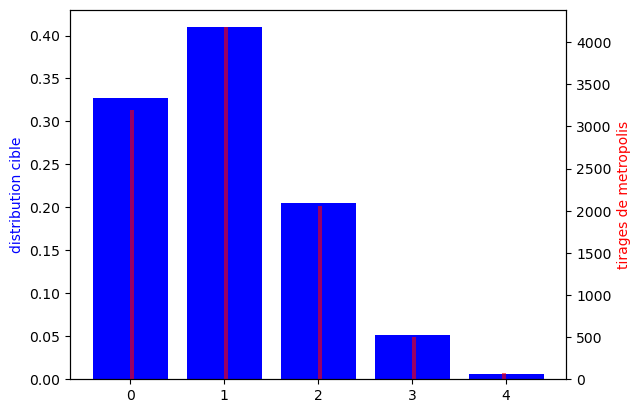

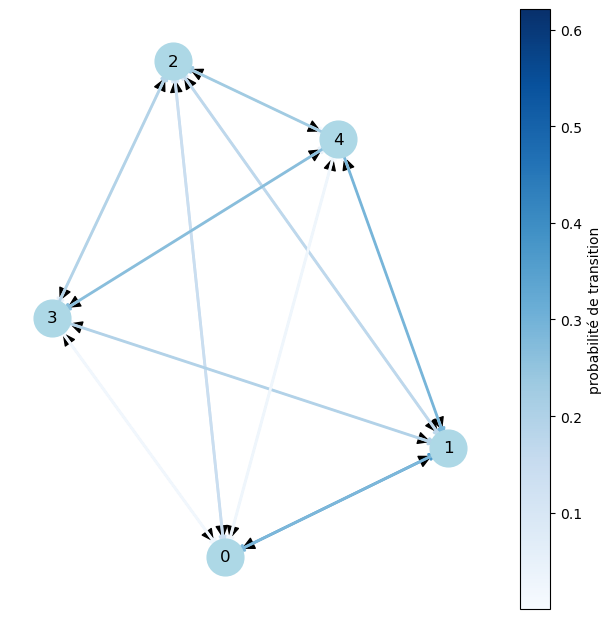

In [ ]:
fig, ax1 = plt.subplots()

X = [i for i in range(N)]
data1 = [distribution_cible(i) for i in X]
data2 = tirage

ax1.set_ylabel("distribution cible",color = "blue")
ax1.bar(X,data1,color="blue")

ax2 = ax1.twinx()

ax2.hist(tirage,bins=100,color="red",alpha=0.6)
ax2.set_ylabel("tirages de metropolis",color="red")

my_plot_graph_mat(mk_c)


plt.show()

In [ ]:
# Démonstration loi de poisson
N = 15

distribution_cible = poisson(5)

#matrice de transition uniforme de taille NxN
proposition = np.full((N,N),1/N)

tirage = hastings_metropolis_tirage(0,distribution_cible,proposition,iterations=100_000)
mk_c = markov_chain_from_tirage(tirage,N)

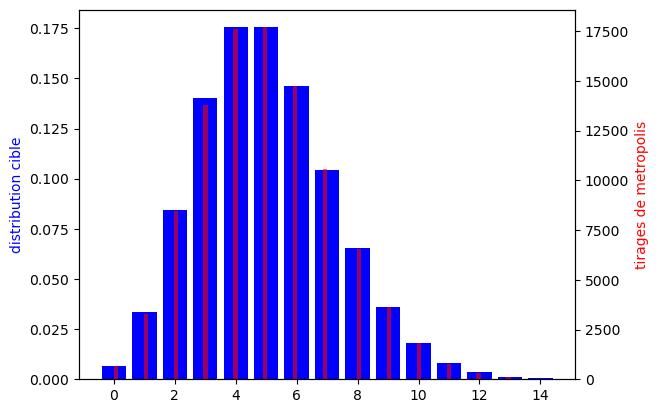

In [ ]:
fig, ax1 = plt.subplots()

X = [i for i in range(N)]
data1 = [distribution_cible(i) for i in X]
data2 = tirage

ax1.set_ylabel("distribution cible",color = "blue")
ax1.bar(X,data1,color="blue")

ax2 = ax1.twinx()

ax2.hist(tirage,bins=100,color="red",alpha=0.6)
ax2.set_ylabel("tirages de metropolis",color="red")

#my_plot_graph_mat(mk_c)

plt.show()

In [ ]:
# Démonstration loi binomial
N = 17

distribution_cible = binomial(20,0.3)

#matrice de transition
proposition = np.array([[binomial(N-1,0.5)(j) for j in range(N)]for i in range(N)])

tirage = hastings_metropolis_tirage(0,distribution_cible,proposition,iterations=100_000)
mk_c = markov_chain_from_tirage(tirage,N)

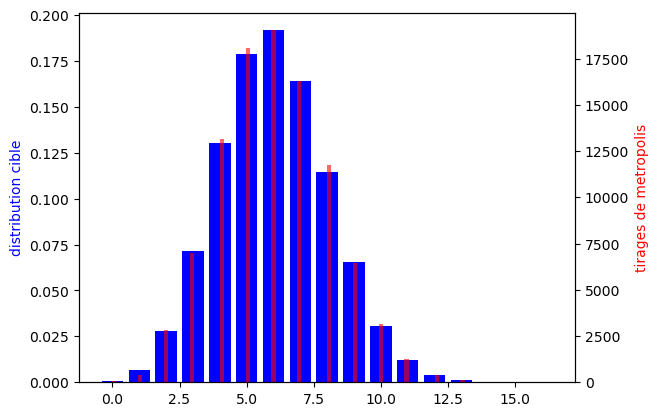

In [ ]:
fig, ax1 = plt.subplots()

X = [i for i in range(N)]
data1 = [distribution_cible(i) for i in X]
data2 = tirage

ax1.set_ylabel("distribution cible",color = "blue")
ax1.bar(X,data1,color="blue")

ax2 = ax1.twinx()

ax2.hist(tirage,bins=100,color="red",alpha=0.6)
ax2.set_ylabel("tirages de metropolis",color="red")

plt.show()

In [ ]:
# Démonstration loi uniform

N = 15

distribution_cible = lambda k : 1/(N-2) if 0<k and k<N else 0

#matrice de transition aléatoire
proposition = np.array([ ligne / ligne.sum()
    for ligne in [np.random.rand(N) for _ in range(N)]
])


tirage = hastings_metropolis_tirage(0,distribution_cible,proposition,iterations=100_000)
mk_c = markov_chain_from_tirage(tirage,N)

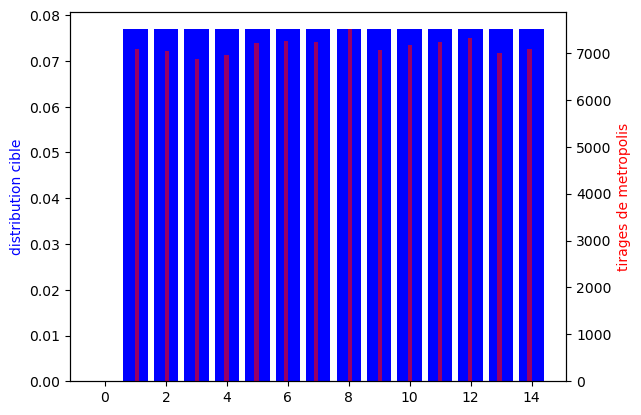

In [ ]:
fig, ax1 = plt.subplots()

X = [i for i in range(N)]
data1 = [distribution_cible(i) for i in X]
data2 = tirage

ax1.set_ylabel("distribution cible",color = "blue")
ax1.bar(X,data1,color="blue")

ax2 = ax1.twinx()

ax2.hist(tirage,bins=100,color="red",alpha=0.6)
ax2.set_ylabel("tirages de metropolis",color="red")


plt.show()

In [ ]:
# Démonstration loi géometrique

N = 20

distribution_cible = geo(0.33)

#matrice de transition aléatoire
proposition = np.array([ ligne / ligne.sum()
    for ligne in [np.array([abs(np.random.normal(i,1)) for _ in range(N)]) for i in range(N)]
])

tirage = hastings_metropolis_tirage(0,distribution_cible,proposition,iterations=100_000)
mk_c = markov_chain_from_tirage(tirage,N)

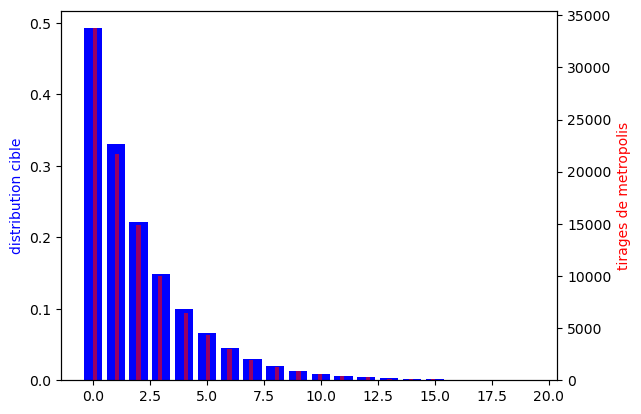

In [ ]:
fig, ax1 = plt.subplots()

X = [i for i in range(N)]
data1 = [distribution_cible(i) for i in X]
data2 = tirage

ax1.set_ylabel("distribution cible",color = "blue")
ax1.bar(X,data1,color="blue")

ax2 = ax1.twinx()

ax2.hist(tirage,bins=100,color="red",alpha=0.6)
ax2.set_ylabel("tirages de metropolis",color="red")

plt.show()

In [ ]:
# Démonstration loi quelconque

N = 30

distribution = np.random.rand(N)
distribution = distribution / distribution.sum()

distribution_cible = lambda k : distribution[k] if k < N and 0<=k else 0

#matrice de transition aléatoire
proposition = np.array([ ligne / ligne.sum()
    for ligne in [np.array([abs(np.random.normal(i,1)) for _ in range(N)]) for i in range(N)]
])

tirage = hastings_metropolis_tirage(0,distribution_cible,proposition,iterations=100_000)
mk_c = markov_chain_from_tirage(tirage,N)

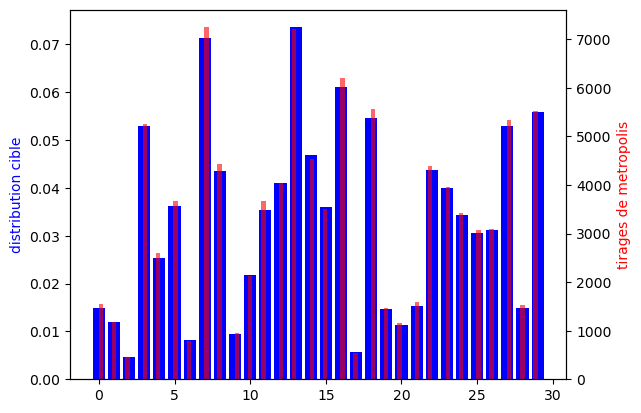

In [ ]:
fig, ax1 = plt.subplots()

X = [i for i in range(N)]
data1 = [distribution_cible(i) for i in X]
data2 = tirage

ax1.set_ylabel("distribution cible",color = "blue")
ax1.bar(X,data1,color="blue")

ax2 = ax1.twinx()

ax2.hist(tirage,bins=100,color="red",alpha=0.6)
ax2.set_ylabel("tirages de metropolis",color="red")


plt.show()

## Application au problème du voaygeur de commerce
<!-- 

### Algorithme

Nous avons un nombre $n \in \mathbb{N} $ de villes, ordonnés,  $(v_1, v_2, \dots, v_n)$, avec des coordonées donnée par $C(v_i) = (x,y) \in \mathbb{R}^2, \forall i \in [1,n]$

L'ensemble des états $E$, est l'ensembles des combinaisons de nos villes 

Nous posons aussi $\mathcal{D}(X) = \sum_{i=0}^{n-1} \|C(v_i) - C_(v_{i+1}) \| $ ordonnées selon $X$

Nous avons la distributions cible $\pi(X) = e^{-\mathcal{D}(X)/T}$, avec $T \in \mathbb{R} $

Nous définissons la matrice de transition $P$  -->

In [17]:
def echanger_ville(p):
    p_new = p.copy()
    i, j = np.random.choice(len(p), size=2, replace=False)
    p_new[i], p_new[j] = p_new[j], p_new[i]
    return p_new

def distance_total(tournee, distances):
    return sum(distances[tournee[i], tournee[(i+1) % len(tournee)]] for i in range(len(tournee)))

def tsp_distribution_cible(tournee, distances, beta=1):
    return np.exp(-beta * distance_total(tournee, distances))
    

In [18]:

def hastings_metropolis_tsp(p0, distances, beta=1.0, iterations = 1_000):
    p_t = p0.copy()
    tirage = [p_t.copy()]

    for _ in range(iterations):
        p_prime = echanger_ville(p_t)

        pi_pt = tsp_distribution_cible(p_t, distances, beta)
        pi_p = tsp_distribution_cible(p_prime, distances, beta)

        #proposition symétrique :
        alpha = min(1, pi_p/pi_pt) if pi_pt > 0 else 1

        u = np.random.uniform()
        if u <= alpha:
            p_t = p_prime
        
        tirage.append(p_t.copy())
    
    return tirage

def meilleur_solution(tirage, distances):
    return min(tirage, key=lambda tour: distance_total(tour, distances))

In [33]:
#retourne simplement des coordonées aléatoire
def generer_villes(n):
    return np.random.rand(n,2)

def matrice_distances(villes):
    return np.linalg.norm(villes[:, np.newaxis] - villes, axis=2)

import matplotlib.pyplot as plt

def tracer_tournee(villes, tournee, titre="Tournée avec direction", ax=None):
    tournee = tournee + [tournee[0]]

    # Créer une figure/axe si non fourni
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
        show_plot = True
    else:
        show_plot = False

    # Tracer les flèches
    for i in range(len(tournee) - 1):
        a = villes[tournee[i]]
        b = villes[tournee[i+1]]

        dx, dy = b[0] - a[0], b[1] - a[1]
        ax.arrow(a[0], a[1], dx, dy, 
                 head_width=0.02, head_length=0.03, 
                 length_includes_head=True, 
                 fc='blue', ec='blue')

    # Tracer les villes
    for i, ville in enumerate(villes):
        if i == 0:
            ax.plot(ville[0], ville[1], 'ro')
        else:
            ax.plot(ville[0], ville[1], 'o', color="#00FF00")
        ax.text(ville[0]+0.01, ville[1]+0.01, str(i), fontsize=12)

    ax.set_title(titre)
    ax.set_aspect('equal')
    ax.grid(True)

    if show_plot:
        plt.show()


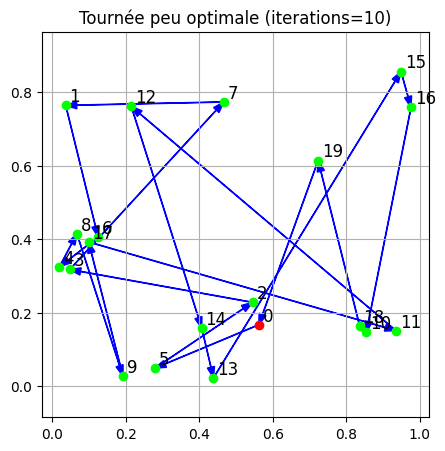

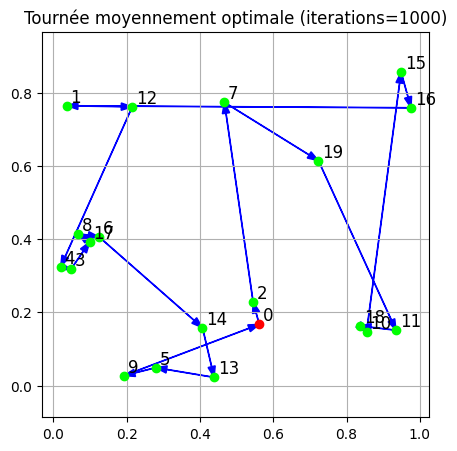

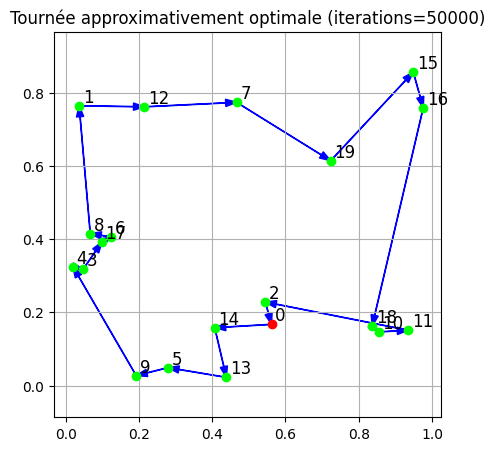

In [ ]:
n_villes = 20
villes = generer_villes(n_villes)
distances = matrice_distances(villes)
p0 = list(range(n_villes))


tirage = hastings_metropolis_tsp(p0, distances, beta=5.0, iterations=10)
meilleur = meilleur_solution(tirage, distances)

tracer_tournee(villes, meilleur, titre="Tournée peu optimale (iterations=10)")


tirage = hastings_metropolis_tsp(p0, distances, beta=5.0, iterations=1000)
meilleur = meilleur_solution(tirage, distances)

tracer_tournee(villes, meilleur, titre="Tournée moyennement optimale (iterations=1000)")

tirage = hastings_metropolis_tsp(p0, distances, beta=5.0, iterations=50000)
meilleur = meilleur_solution(tirage, distances)

tracer_tournee(villes, meilleur, titre="Tournée approximativement optimale (iterations=50000)")

Distance trouvée : 34.133143506371304


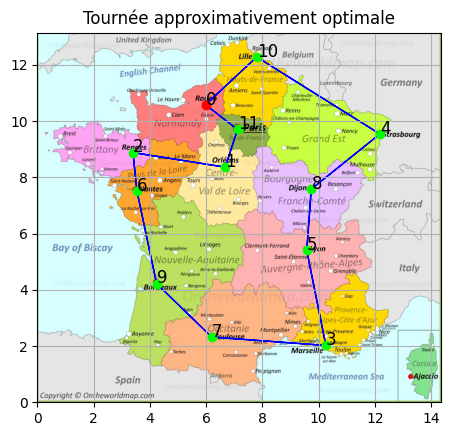

In [35]:
n_villes = 12
villes = np.array([
    [7.12,9.7],  #Paris
    [5.98,10.58],#Rouen
    [7.8,12.28], #Lille
    [10.26,2.02], #Marseille
    [12.18,9.54], #Strasbourg
    [9.74,7.58], #Dijon
    [9.58,5.4], #Lyon
    [6.2,2.32], #Toulouse
    [4.24,4.22], #Bordeaux
    [3.54,7.52], #Nantes
    [3.4,8.88],  #Rennes
    [6.68,8.36], #Orléans
])
img = mpimg.imread('../ressources/externs/carte_france.png') 

xmin, xmax = 0, 1306/91
ymin, ymax = 0, 1196/91

np.random.shuffle(villes)

distances = matrice_distances(villes)
p0 = list(range(n_villes))

tirage = hastings_metropolis_tsp(p0, distances, beta=5.0, iterations=10_000)
meilleur = meilleur_solution(tirage, distances)

print("Distance trouvée :", distance_total(meilleur, distances))

fig, ax = plt.subplots()
ax.imshow(img, extent=[xmin, xmax, ymin, ymax])  # Adjust extent to match your data range

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

tracer_tournee(villes, meilleur, titre="Tournée approximativement optimale", ax=ax)
plt.show()

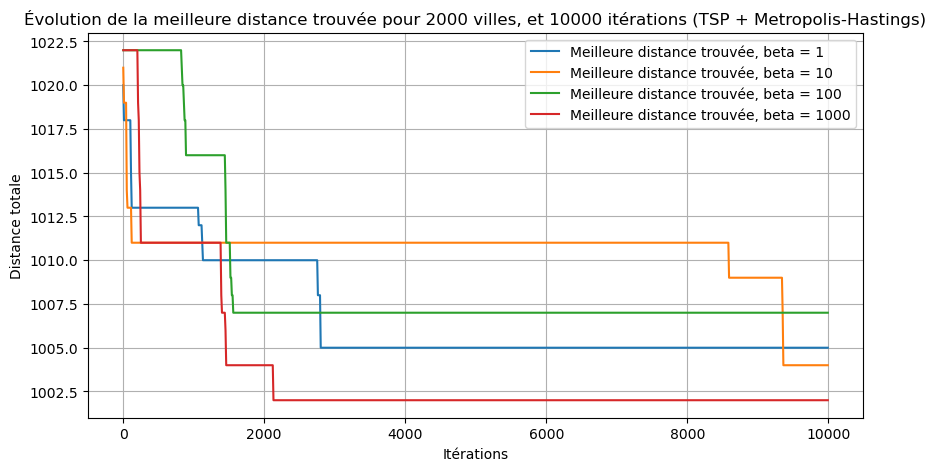

In [ ]:
n_villes = 2000
ITER = 10_000
pas = 10

villes = generer_villes(n_villes)
distances = matrice_distances(villes)
p0 = list(range(n_villes))

tirage1 = hasting_metropolis_tsp(p0, distances, beta=1.0, iterations=ITER)
tirage2 = hasting_metropolis_tsp(p0, distances, beta=10.0, iterations=ITER)
tirage3 = hasting_metropolis_tsp(p0, distances, beta=100.0, iterations=ITER)
tirage4 = hasting_metropolis_tsp(p0, distances, beta=1000.0, iterations=ITER)


X = np.arange(1, ITER, pas)
Y1 = np.zeros_like(X)
Y2 = np.zeros_like(X)
Y3 = np.zeros_like(X)
Y4 = np.zeros_like(X)

sol1 = distance_total(tirage[0], distances)
sol2 = distance_total(tirage[0], distances)
sol3 = distance_total(tirage[0], distances)
sol4 = distance_total(tirage[0], distances)

for i, x in enumerate(range(0, ITER - 1, pas)):
    current_best1 = meilleur_solution(tirage1[x:x+pas], distances)
    sol1 = min(sol1, distance_total(current_best1, distances))
    Y1[i] = sol1

    current_best2 = meilleur_solution(tirage2[x:x+pas], distances)
    sol2 = min(sol2, distance_total(current_best2, distances))
    Y2[i] = sol2

    current_best3 = meilleur_solution(tirage3[x:x+pas], distances)
    sol3 = min(sol3, distance_total(current_best3, distances))
    Y3[i] = sol3

    current_best4 = meilleur_solution(tirage4[x:x+pas], distances)
    sol4 = min(sol4, distance_total(current_best4, distances))
    Y4[i] = sol4

plt.figure(figsize=(10, 5))
plt.plot(X, Y1, label="Meilleure distance trouvée, beta = 1")
plt.plot(X, Y2, label="Meilleure distance trouvée, beta = 10")
plt.plot(X, Y3, label="Meilleure distance trouvée, beta = 100")
plt.plot(X, Y4, label="Meilleure distance trouvée, beta = 1000")
plt.xlabel("Itérations")
plt.ylabel("Distance totale")
plt.title(f"Évolution de la meilleure distance trouvée pour {n_villes} villes, et {ITER} itérations (TSP + Metropolis-Hastings)")
plt.grid(True)
plt.legend()
plt.show()